<a href="https://colab.research.google.com/github/tonytsai5583/colab20230710/blob/main/Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

前言

藉由 Kaggle 上鐵達尼號生存預測比賽，我們簡單地分享有關資料的分析及處理技巧，除希望文中的程式碼範本能幫助初心者們快速上手外，更希望能使讀者瞭解一個機器學習專案的基本構思及流程，通常一個機器學習專案，我們會耗費絕大部分的時間在資料分析與特徵工程上，模型的選用及調整參數是不太需要花時間的。因此，一個專案要能順利進行，除需具備熟練的程式語言外，該領域的專業知識及實務經驗，更是一大關鍵的因素。

In [49]:
from posixpath import abspath
import os
print(os.path.abspath('.'))
print(os.path.abspath('..'))
print(os.path.abspath('Titanic.ipynb'))

/content
/
/content/Titanic.ipynb


滙入相關套件

In [50]:
#pip install sklearn
import pandas as pd
import numpy as np

# 繪圖相關套件
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.gridspec as gridspec
import seaborn as sns
plt.style.use( 'ggplot' ) #使用ggplot之佈景主題

# 標籤編碼(Label)、獨熱編碼(OneHot)
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
# 決策樹(Decision Tree)
from sklearn.tree import DecisionTreeClassifier
# 隨機森林(Random Forest)
from sklearn.ensemble import RandomForestClassifier

from IPython.display import display
import warnings
warnings.filterwarnings( 'ignore' ) #通过警告过滤器进行控制是否发出警告消息

# 滙入資料並顯示資料

透過 pandas 匯入訓練集與測試集資料，並利用 shape 得知資料的維度：

訓練集有 891 筆資料、12 個特徵欄位；
測試集有 418 筆資料、11 個特徵欄位；
其中，訓練集較測試集多了判別乘客罹難或生還的特徵欄位 Survived，0 表示罹難者，1 表示生還者。

In [51]:
df_train = pd.read_csv('./sample_data/train.csv')
df_test = pd.read_csv('./sample_data/test.csv')
submit = pd.read_csv('./sample_data/gender_submission.csv')

print( f'train {df_train.shape}' )
display( df_train.head() )

print( f'\ntest {df_test.shape}' )
display( df_test.head() )

train (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S



test (418, 11)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [52]:
# 定義判別欄位型態的函數
def Col_Types( Data ):
    Column_Types = Data.dtypes.to_frame().reset_index()   # 判別每個欄位的型態
    Column_Types.columns = ['ColumnName','Type']
    Column_Types.sort_values( by='Type', inplace=True )
    return Column_Types

In [53]:
display( Col_Types(df_train) )

,ColumnName,Type
0,PassengerId,int64
1,Survived,int64
2,Pclass,int64
6,SibSp,int64
7,Parch,int64
5,Age,float64
9,Fare,float64
3,Name,object
4,Sex,object
8,Ticket,object


In [54]:
# 定義用來統計欄位缺漏值總數的函數
def Missing_Counts( Data ) :
    missing = Data.isnull().sum()  # 計算欄位中缺漏值的數量
    missing = missing[ missing>0 ]
    missing.sort_values( inplace=True )

    Missing_Count = pd.DataFrame( { 'ColumnName':missing.index, 'MissingCount':missing.values } )  # Convert Series to DataFrame
    Missing_Count[ 'Percentage(%)' ] = Missing_Count['MissingCount'].apply( lambda x:round(x/Data.shape[0]*100,2) )
    return  Missing_Count

在分析資料之前，我們還需先檢視資料是否存有缺漏值(Missing Values)，如果欄位存有缺漏值，之後在特徵工程(Feature Engineering)的過程中，我們可視欄位中缺漏值的比例或對預測值的相關性，決定填補或排除此欄位的處理方法。
透過我們自定義的函數 Missing_Counts ，發現 Embarked、Fare、Cabin、Age 欄位有缺漏值，當中， Cabin 欄位的缺漏情況最為嚴重，訓練集中約有 77%、測試集中約有 78% 的缺漏值，其次為 Age 欄位，訓練集中約有 20%、測試集中約有 21% 的缺漏值。

In [55]:
print( 'train :' )
display( Missing_Counts(df_train) )

print( 'test :' )
display( Missing_Counts(df_test) )

train :


,ColumnName,MissingCount,Percentage(%)
0,Embarked,2,0.22
1,Age,177,19.87
2,Cabin,687,77.10


test :


,ColumnName,MissingCount,Percentage(%)
0,Fare,1,0.24
1,Age,86,20.57
2,Cabin,327,78.23


In [56]:
print( 'train' )
display( df_train.describe() )

print( 'test' )
display( df_test.describe() )

train


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


test


,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


利用 describe( ) 函數

我們可得到每個數值型態欄位的統計量，其用意是為往後我們在觀察欄位是否存有離群值(Outlier)時，作為一個判斷的參考依據，另外，也可用來觀察每個欄位的尺度(scale)是否相似，在餵資料進入模型訓練之前，決定是否需進行資料的正規化(Normalization)或標準化(Standardization)。

資料分析(Data Analysis)

在大致瞭解資料的基本態樣後，我們便可開始對資料做一些關聯性分析。由於是對整體資料進行分析，因此我們先使用 append( ) 函數將訓練集與測試集合併，方便後續一併修補或調整資料。

In [57]:
# 合併train及test的資料
#datas_total = pd.concat([df_train, df_test],axis=0)
#datas_total
df_data = df_train.append( df_test )
df_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


生還者的比率(Survival Ratio)

首先，我們分析生還者與罹難者的比例是否有明顯極大的落差，比如生還者的比例僅有 1%，若資料有極大的落差時，表示存在『數據不平衡』(Imbalanced Data)的問題，則後續需用特別的方法對資料進行抽樣。利用 value_counts( ) 函數，我們可以計算欄位中各相異類別的數量，船難中的生還者約佔全體乘客的 38.38%、罹難者約佔 61.62%。

In [58]:
Survived_Counts = df_data['Survived'].value_counts().reset_index()
Survived_Counts.columns = ['Survived','Counts']
Survived_Counts

,Survived,Counts
0,0.0,549
1,1.0,342


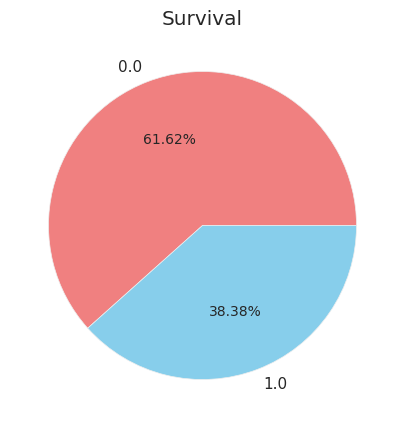

In [59]:
plt.figure( figsize=(10,5) )
df_data['Survived'].value_counts().plot( kind='pie', colors=['lightcoral','skyblue'], autopct='%1.2f%%' )
plt.title( 'Survival' )  # 圖標題
plt.ylabel( '' )
plt.show()

相關係數(Correlation)

利用 corr( ) 函數，計算特徵欄位彼此間的相關係數，可作為後續決定篩選哪些特徵欄位，來餵入模型進行訓練。觀察 Survived 欄位與其他特徵欄位的相關係數，發覺彼此間並無明顯的線性關係。

In [60]:
# Survied 與其他欄位間的相關係數
Corr_Matrix = df_train.corr()  # 計算相關係數
Corr = Corr_Matrix.loc['Survived',:].sort_values()[:-1]
Corr = pd.DataFrame({ 'Survived':Corr })
Corr

,Survived
Pclass,-0.338481
Age,-0.077221
SibSp,-0.035322
PassengerId,-0.005007
Parch,0.081629
Fare,0.257307


生存率(Survival Rate)

接下來，我們分別觀察性別(Sex)、票務艙(Pclass)、登船港口(Embarked)、兄弟姊妹配偶人數(SibSp)、父母子女人數(Parch)與生存率的關係。

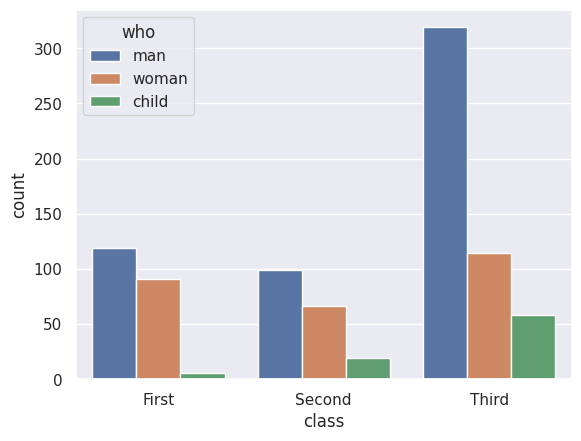

In [61]:
import seaborn as sns
sns.set(style="darkgrid")
titanic = sns.load_dataset("titanic") #titanic经典数据集，带有登船人员的信息
#源数据集class代表三等舱位，who代表人员分类，男女小孩，对每一类人数计数
ax = sns.countplot(x="class", hue="who", data=titanic)

ValueError: ignored

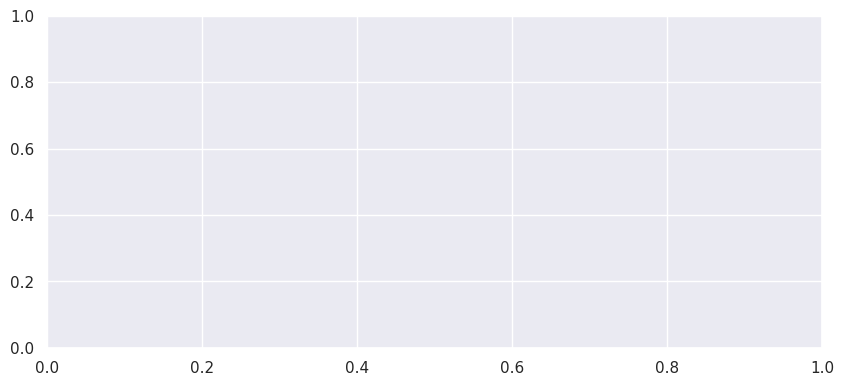

In [72]:
# Sex性別、Pclass票務艙、imEmbarked登船港口、SibSp兄弟姊妹配偶人數、Parch父母子女人數
import seaborn as sns
sns.set(style="darkgrid")
selected_cols = ['Sex','Pclass','Embarked','SibSp','Parch']

plt.figure(figsize=(10,len(selected_cols)*5))
gs = gridspec.GridSpec(len(selected_cols),1)
for i, col in enumerate(df_data[selected_cols]) :
   ax = plt.subplot(gs[i])
   sns.countplot(df_data[col], hue=df_data.Survived, palette = ['lightcoral','skyblue'])
   ax.set_yticklabels([])
   ax.set_ylabel('Counts')
   ax.legend( loc=1 )   # upper right:1 ; upper left:2
   for p in ax.patches:
    ax.annotate('{:,}'.format(p.get_height()), (p.get_x(), p.get_height()+1.5))
plt.show()




In [73]:
for col in selected_cols:
    l = ['Survived']
    l.append(col)
    Survival_Rate = df_data[l].groupby(by=col).mean().round(4).reset_index()
    Survival_Rate.columns = [col,'Survival Rate(%)']
    Survival_Rate['Survival Rate(%)'] = Survival_Rate['Survival Rate(%)'].map( lambda x:x*100 )
    display( Survival_Rate )

,Sex,Survival Rate(%)
0,female,74.20
1,male,18.89


,Pclass,Survival Rate(%)
0,1,62.96
1,2,47.28
2,3,24.24


,Embarked,Survival Rate(%)
0,C,55.36
1,Q,38.96
2,S,33.70


,SibSp,Survival Rate(%)
0,0,34.54
1,1,53.59
2,2,46.43
3,3,25.00
4,4,16.67
5,5,0.00
6,8,0.00


,Parch,Survival Rate(%)
0,0,34.37
1,1,55.08
2,2,50.00
3,3,60.00
4,4,0.00
5,5,20.00
6,6,0.00
7,9,NaN


透過上列的長條圖(Bar Plot)與統計表，我們可得到下列的觀察：

女性的生存率明顯高於男性；
票務艙( Pclass )的生存率大小: Pclass 1 > Pclass 2 > Pclasss 3；
登船港口( Embarked )的生存率以 C 最高；
當船上的兄弟姐妹配偶人數( SibSp )有 1 人同行時，則生存率較高；
當船上的父母子女人數( Parch )為 1~3 人時，有較高的生存率。

由於 SibSp 與 Parch 欄位所記錄的人數皆屬於家庭成員，所以我們將兩者相加創造新的特徵欄位稱家庭人數(Family_Size)，並觀察 Family_Size 與生存率的關係，發現當家庭人數為4時的生存率(約 72.4%)明顯高於其他人數。

In [74]:
# 創造新的特徵變數：家庭人數(Family_Size)
df_data['Family_Size'] = df_data['SibSp'] + df_data['Parch'] + 1

Survival_Rate = df_data[['Family_Size','Survived']].groupby(by=['Family_Size']).agg(np.mean)*100
Survival_Rate.columns = ['Survival Rate(%)']
Survival_Rate.reset_index()

,Family_Size,Survival Rate(%)
0,1,30.353818
1,2,55.279503
2,3,57.843137
3,4,72.413793
4,5,20.000000
5,6,13.636364
6,7,33.333333
7,8,0.000000
8,11,0.000000


透過上列 Family_Size 欄位與生存率的關係，我們將 Family_Size 的生存率做級別的區分(3 表示生存率最高、1 為最低)。

In [75]:
df_data[ 'Family_Class' ] = np.nan

df_data.loc[ df_data.Family_Size==0, 'Family_Class' ] = 2
df_data.loc[ (df_data.Family_Size>=1) & (df_data.Family_Size<=3), 'Family_Class' ] = 3
df_data.loc[ (df_data.Family_Size>=4) & (df_data.Family_Size<=6), 'Family_Class' ] = 2
df_data.loc[ (df_data.Family_Size>=7), 'Family_Class' ] = 1

另外，就整體而言，女性乘客的生存率(74%)明顯高於男性(19%)，此時我們想更深入探討，在不同票務艙(Pclass)中的男性及女性，生存率是否也有明顯的差別？我們發現在 Pclass 1 與 Pclass 2 中，男女的生存率差異性更是明顯！！其中，在 Pclass 1 中的女性乘客生存率更是高達約 97%。

In [ ]:
# Sex & Pclass
Survival_Rate = df_data[['Sex','Pclass','Survived']].groupby(by=['Sex','Pclass']).agg(np.mean)*100
Survival_Rate.columns = ['Survival Rate(%)']
Survival_Rate.reset_index()

相似的手法，我們依據在不同艙等中的男女性生存率，給予不同的生存率級別(3最高、1最小)：

In [ ]:
df_data[ 'Sex_Pclass' ] = np.nan
df_data.loc[ (df_data.Sex=='female') & (df_data.Pclass==1), 'Sex_Pclass' ] = 2
df_data.loc[ (df_data.Sex=='female') & (df_data.Pclass==2), 'Sex_Pclass' ] = 3
df_data.loc[ (df_data.Sex=='female') & (df_data.Pclass==3), 'Sex_Pclass' ] = 3
df_data.loc[ (df_data.Sex=='male') & (df_data.Pclass==1), 'Sex_Pclass' ] = 1
df_data.loc[ (df_data.Sex=='male') & (df_data.Pclass==2), 'Sex_Pclass' ] = 1
df_data.loc[ (df_data.Sex=='male') & (df_data.Pclass==3), 'Sex_Pclass' ] = 2

特徵工程(Feature Engineering)

在分析觀察完資料後，我們接著將處理一些無法直接餵入模型的特徵欄位，例如： Name 欄位為字串、Cabin 欄位中存有大量的缺漏值等。

(1) 字串欄位處理

Name (姓名)

首先，我們可先觀察 Name 欄位，發現可以擷取出稱謂(Title)的資訊，來幫助提升模型預測的準確度。一般在處理字串資料時，常用的函數有 split( )、repalce( ) 等來分割或取代字串中的文字，再比較程式語法化的方法可參考正規表示法(Regular Expression)，這裏我們分別練習兩種方法：split( ) 與正規表示法，來擷取出 Name 欄位中的稱謂，產生的結果將僅有一個不同，其他皆完全相同：

In [ ]:
# Method 1: split()
df_data['Title'] = df_data.Name.str.split(', ', expand=True)[1]
df_data['Title'] = df_data.Title.str.split('.', expand=True)[0]
df_data['Title'].unique()

In [ ]:
# Method 2: 正規表示法(Regular Expression)
import re

regex = re.compile( ' ([A-Za-z]+)\.' )
df_data['Title'] = df_data.Name.map( lambda x:regex.search(x)[0] )
# Dropping the first and the last words
df_data['Title'] = df_data.Title.map( lambda x:x[1:][:-1] )
df_data['Title'].unique()

將同樣性別或關係的稱謂合併，避免產生某些稱謂僅有少數乘客，例如：Rev(Reverend)為牧師的尊稱、Countess為伯爵夫人等，影響模型的預測準確度。這裏我們將利用 replace( ) 函數，將上述擷取出的稱謂總歸為五類：Mr、Mrs、Miss、Master、Rare。

In [ ]:
df_data['Title'] = df_data.Title.replace( ['Don','Rev','Dr','Major','Lady','Sir','Col','Capt','Countess','Jonkheer','Dona'], 'Rare' )
df_data['Title'] = df_data.Title.replace( ['Ms','Mlle'], 'Miss' )
df_data['Title'] = df_data.Title.replace( 'Mme', 'Mrs' )
df_data['Title'].unique()

In [ ]:
# 刪除原始資料中的 Name 欄位
df_data.drop( 'Name', axis=1, inplace=True )

船票號碼(Ticket)

另外，我們合理假設 Ticket 中，前面英文字母的部份代表房間位於相同的區域中，我們再次利用 split( ) 及 repalce( ) 函數，來擷取 Ticket 字串中前面英文字母的部份文字訊息，作為乘客艙房的位置分區。

In [76]:
df_data['Ticket_info'] = df_data.Ticket.apply( lambda x:x.replace('.','').replace('/','').strip().split(' ')[0] if not x.isdigit() else 'X')
df_data['Ticket_info'].unique()

array(['A5', 'PC', 'STONO2', 'X', 'PP', 'CA', 'SCParis', 'SCA4', 'A4',
       'SP', 'SOC', 'WC', 'SOTONOQ', 'WEP', 'STONO', 'C', 'SCPARIS',
       'SOP', 'Fa', 'LINE', 'FCC', 'SWPP', 'SCOW', 'PPP', 'SC', 'SCAH',
       'AS', 'SOPP', 'FC', 'SOTONO2', 'CASOTON', 'SCA3', 'STONOQ', 'AQ4',
       'A', 'LP', 'AQ3'], dtype=object)

In [77]:
# 刪除原始資料中的 Ticket 欄位
df_data.drop( 'Ticket', axis=1, inplace=True )

(2) 填補缺漏值(Missing Values)

針對存有缺漏值的欄位：Embarked、Fare、Cabin 及 Age 進行補值。一般而言，我們常選擇用平均值(Mean)、中位數(Median)或眾數(Mode)等補值，且利用 fillna( ) 函數來執行填補的動作，另外，較為進階的做法是透過機器學習模型進行補值，如：線性迴歸模型(Linear Regression)、決策樹(Decision Tree Regressor)等。
在補缺漏值前，我們再次查看整體資料的缺漏值分佈情況：

In [78]:
Missing_Counts( df_data.drop('Survived', axis=1) )

,ColumnName,MissingCount,Percentage(%)
0,Fare,1,0.08
1,Embarked,2,0.15
2,Age,263,20.09
3,Cabin,1014,77.46


票價(Fare) : 填補整體票價的中位數

In [79]:
df_data['Fare'].fillna( df_data.Fare.median(), inplace=True )

登船港口(Embarked) : 填補次數最多的港口 'S'

In [81]:
# 計算 Embarked 欄位中每個相異值的次數
display( df_data['Embarked'].value_counts() )
# 填補 Embarked 欄位的缺漏值
df_data['Embarked'].fillna( 'S', inplace=True )

S    914
C    270
Q    123
Name: Embarked, dtype: int64

年齡(Age) :

因為 Age 欄位的缺漏值佔比約有 20% ，不像前面 Fare 及 Embarked 欄位中僅有少數不到 1% 的缺漏值，因此我們所填補缺漏的值可能會影響預測的結果。此時，我們先藉由 Age 搭配 Sex 或 Pclass 欄位，觀察缺漏值分布的情況，檢視缺漏值是否集中發生在某類特別的乘客當中？

In [82]:
# 新增標註 Age 欄位是否為缺漏值的欄位(有缺漏標為0)
df_data['isAge'] = df_data['Age'].isnull().map( lambda x:0 if x==True else 1 )

In [83]:
# 分別觀察 Age 與 Sex、Pclass 的缺漏值分布狀況
display( pd.crosstab( df_data.isAge, df_data.Sex, margins=True ) )
display( pd.crosstab( df_data.isAge, df_data.Pclass, margins=True ) )

Sex,female,male,All
isAge,,,
0,78,185,263
1,388,658,1046
All,466,843,1309


Pclass,1,2,3,All
isAge,,,,
0,39,16,208,263
1,284,261,501,1046
All,323,277,709,1309


ValueError: ignored

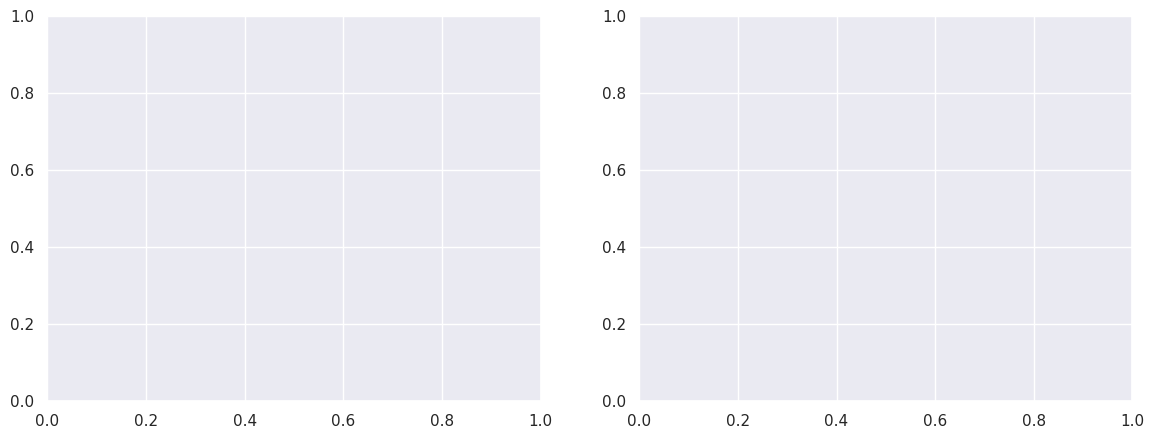

In [84]:
fig, axs = plt.subplots(1,2,figsize=(14,5))
#plt.suptitle('Age')

plt.subplot(1,2,1)
sns.countplot( df_data.Sex, hue=df_data.isAge, palette=['lightcoral','skyblue'] )
plt.ylabel( 'Counts' )

plt.subplot(1,2,2)
sns.countplot( df_data.Pclass, hue=df_data.isAge, palette=['lightcoral','skyblue'] )
plt.ylabel( '' )

plt.show()

經觀察上表及圖後可知，Age 欄位的缺漏值明顯分佈在 Pclass 3 中，約佔 29.34%(=208/709)，進一步觀察在 Pclass 1 及 Pclass 2 的乘客中，Age 欄位對於存活率是否有明顯的影響？

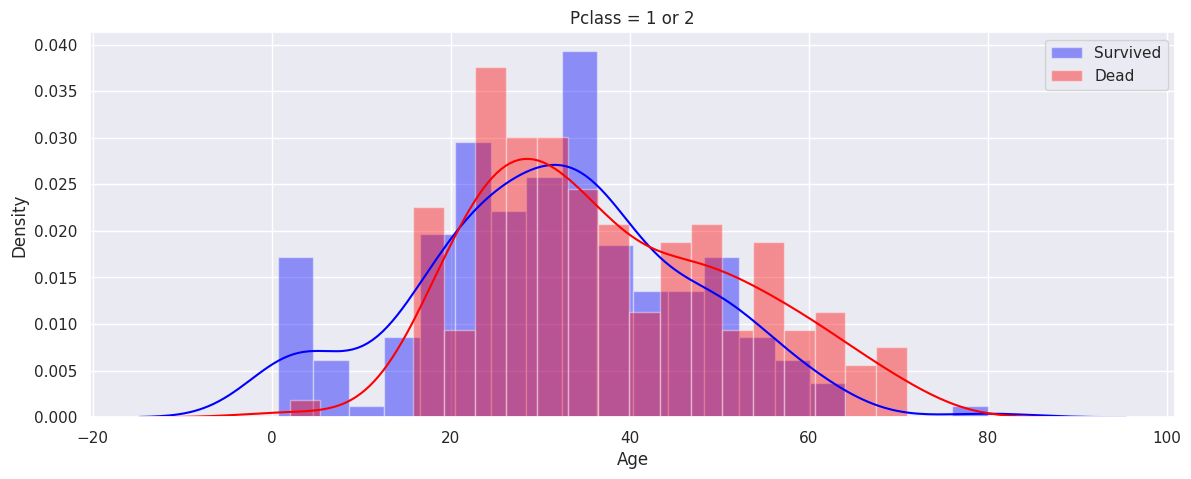

In [85]:
index_S = (df_data.isAge==1)&(df_data.Pclass!=3)&(df_data.Survived==1)
index_D = (df_data.isAge==1)&(df_data.Pclass!=3)&(df_data.Survived==0)

plt.figure( figsize=(14,5) )
sns.distplot( df_data.loc[index_S,'Age'], bins=20, color='blue', label='Survived' )
sns.distplot( df_data.loc[index_D,'Age'], bins=20, color='red', label='Dead' )
plt.title( 'Pclass = 1 or 2' )
plt.legend( )
plt.show( )

從上圖可觀察到，在 Pclass 1 及 Pclass 2 的乘客中，年齡約小於 17 歲的乘客中有明顯較高的生存率，若年齡超過 17 歲則生存率並無明顯的差別，所以我們可大膽假設 Age 欄位與生存率具有關聯性，另外，因為年齡與稱謂(Title)也有相當程度的關聯，因此，我們將先計算每個稱謂的年齡平均值，再用此平均值來填補每個 Title 中所對應 Age 欄位的缺漏值。

In [86]:
# 計算每個 Title 的年齡平均值及中位數
Age_Mean = df_data[['Title','Age']].groupby( by=['Title'] ).mean()
Age_Median = df_data[['Title','Age']].groupby( by=['Title'] ).median()

Age_Mean.columns = ['Age Mean']
Age_Median.columns = ['Age Median']
Age_Mean.reset_index( inplace=True )
Age_Median.reset_index( inplace=True )

display( Age_Median )
display( Age_Mean )

KeyError: ignored

In [87]:
# 利用每個 Title 的年齡平均數，填補每個 Title 所對應 Age 的缺漏值
df_data.loc[(df_data.Age.isnull())&(df_data.Title=='Master'),'Age'] = Age_Mean.loc[Age_Mean.Title=='Master','Age Mean'][0]
df_data.loc[(df_data.Age.isnull())&(df_data.Title=='Miss'),'Age'] = Age_Mean.loc[Age_Mean.Title=='Miss','Age Mean'][1]
df_data.loc[(df_data.Age.isnull())&(df_data.Title=='Mr'),'Age'] = Age_Mean.loc[Age_Mean.Title=='Mr','Age Mean'][2]
df_data.loc[(df_data.Age.isnull())&(df_data.Title=='Mrs'),'Age'] = Age_Mean.loc[Age_Mean.Title=='Mrs','Age Mean'][3]
df_data.loc[(df_data.Age.isnull())&(df_data.Title=='Rare'),'Age'] = Age_Mean.loc[Age_Mean.Title=='Rare','Age Mean'][4]

# 刪除 isAge 欄位
df_data.drop( 'isAge', axis=1, inplace=True )

NameError: ignored

填滿 Age 欄位的缺漏值後，我們將年齡特徵再區分成未滿17歲及17歲以上，未滿17歲的乘客標為1，17歲以上的乘客標為0。

In [88]:
# 乘客年齡是否未滿17歲(是：1；否：0)
df_data[ 'is_Age_17' ] = (df_data.Age<17)*1
df_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Family_Size,Family_Class,Ticket_info,isAge,is_Age_17
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,NaN,S,2,3.0,A5,1,0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C85,C,2,3.0,PC,1,0
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,NaN,S,1,3.0,STONO2,1,0
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,C123,S,2,3.0,X,1,0
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,NaN,S,1,3.0,X,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,8.0500,NaN,S,1,3.0,A5,0,0
414,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,108.9000,C105,C,1,3.0,PC,1,0
415,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,7.2500,NaN,S,1,3.0,SOTONOQ,1,0
416,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,8.0500,NaN,S,1,3.0,X,0,0


船艙號碼(Cabin) :

因爲整體 Cabin 欄位約有 77% 的缺漏值，我們在觀察 Cabin 欄位中的資料類別後，僅取出頭一個英文字母作為分類的標籤，其他缺漏的欄位以 NoCabin 表示。

In [90]:
# 觀察 Cabin 中的種類
df_data['Cabin'].unique()

array(['NoCabin', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

In [89]:
# 取出 Cabin 中的第一個字母，如果為缺漏值，則以 NoCabin 表示
df_data['Cabin'] = df_data['Cabin'].apply( lambda x:str(x)[0] if not pd.isnull(x) else 'NoCabin' )
df_data['Cabin'].unique()

array(['NoCabin', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

最後，在完成上述缺漏值的填補後，我們再次檢查是否還有缺漏值尚未填補到。

In [91]:
Missing_Counts( df_data.drop('Survived', axis=1) )

,ColumnName,MissingCount,Percentage(%)
0,Age,263,20.09
